In [1]:
#..modified by CHUYAN at September/10/2021; calculate binned P-E/SST/subsidence/ LTS and LWP array for Model: IPSL; (annual-mean, binned 5X5degree,
#.. area-mean data, standardized data) for abrupt4XCO2 experiment, then use the sensitivity of LWP to CCFs to get a Linear regression model to predict
#..d(LWP)/dGMT..

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd

from scipy import stats
from sklearn import linear_model

In [2]:
#..retrieve variables in abrupt-4xCO2 experiment

fpath_abr_ts    = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/ts/gr/v20190118/ts/ts_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_abr_ta    = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/ta/gr/v20190118/ta/ta_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_abr_ps    = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/ps/gr/v20190118/ps/ps_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_abr_wap   = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/wap/gr/v20190118/wap/wap_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_abr_clivi = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/clivi/gr/v20190118/clivi/clivi_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_abr_clwvi = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/clwvi/gr/v20190118/clwvi/clwvi_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_abr_tas   = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/tas/gr/v20190118/tas/tas_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'

fpath_p     = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/pr/gr/v20190118/pr/pr_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'
fpath_e     = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1p1f1/Amon/evspsbl/gr/v20190118/evspsbl/evspsbl_Amon_IPSL-CM6A-LR_abrupt-4xCO2_r1i1p1f1_gr_185001-214912.nc'


f_ts        = netCDF4.Dataset(fpath_abr_ts,'r')
f_ta        = netCDF4.Dataset(fpath_abr_ta,'r')
f_tas       = netCDF4.Dataset(fpath_abr_tas,'r')
f_ps        = netCDF4.Dataset(fpath_abr_ps,'r')
f_wap       = netCDF4.Dataset(fpath_abr_wap,'r')
f_clivi     = netCDF4.Dataset(fpath_abr_clivi,'r')
f_clwvi     = netCDF4.Dataset(fpath_abr_clwvi,'r')

f_pr        = netCDF4.Dataset(fpath_p, 'r')
f_ev        = netCDF4.Dataset(fpath_e, 'r')

lons        = f_ts.variables['lon'][:]
lats        = f_ts.variables['lat']
times       = f_ts.variables['time']


levels      = f_ta.variables['plev']
#print(levels)

In [3]:
#..choose lat 40 -85 °S as the Southern Ocean region
lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))


sfc_T       = f_ts.variables['ts']   #..T_skin, also as SST, shape in (3600, 143, 144)!!, units in K
T_700       = f_ta.variables['ta'][:, 3,:,:]
sfc_P       = f_ps.variables['ps']   #..Units in Pa, surface Pressure

sub         = f_wap.variables['wap'][:, 5,:,:]    #..500mb downward motions
clivi       = f_clivi.variables['clivi']   #..Units in kg m^-2
clwvi       = f_clwvi.variables['clwvi']
tas         = f_tas.variables['tas']   #..2-m air Temperature, for 'gmt'

P           = f_pr.variables['pr']   #..Units in kg m^-2 s^-1 = mm *s^-1
E           = f_ev.variables['evspsbl']
print(sfc_T.shape)

(3600, 143, 144)


In [4]:
print(sfc_P.shape, T_700.shape)
print(tas.shape, P.shape, E.shape)

(3600, 143, 144) (3600, 143, 144)
(3600, 143, 144) (3600, 143, 144) (3600, 143, 144)


In [5]:
Precip =  np.array(P) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip))   #..2.74 /IPSL..2.80
Eva    =  np.array(E) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva))         #..2.43 /IPSL..2.50
print(Eva.shape)   #..variable shape in (3600, 143, 144)


2.8014145
2.5021765
(3600, 143, 144)


In [6]:
#..Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence

LWP  = np.array(clwvi) - np.array(clivi)   #..units in kg m^-2
gmt  = np.array(tas)
SST  = np.array(sfc_T)
MC  = Precip-Eva   #..Moisture Convergence calculated from P - E, Units in mm day^-1

Twp  = np.array(clwvi)
Iwp  = np.array(clivi)


In [7]:
#..Lower Troposphere Stability
k  = 0.286
theta_700  = np.array(T_700)* (100000./70000.)**k

#print(theta_700)

theta_skin = np.array(sfc_T)* (100000./np.array(sfc_P))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m
LTS_e  = np.ma.masked_where(theta_700 >= 500, LTS_m)
print(LTS_e, LTS_m)

#..Subsidence, units in Pa s^-1 at 500 hPa
Subsidence =  np.array(sub)

[[[1.47882080078125 1.47882080078125 1.47882080078125 ...
   1.47882080078125 1.47882080078125 1.47882080078125]
  [3.895782470703125 3.70989990234375 3.505462646484375 ...
   4.364654541015625 4.25885009765625 4.05926513671875]
  [5.834075927734375 5.5068359375 5.241912841796875 ...
   6.496063232421875 6.3214111328125 6.06365966796875]
  ...
  [29.580093383789062 29.61004638671875 29.618148803710938 ...
   29.559494018554688 29.599563598632812 29.5911865234375]
  [29.551498413085938 29.58892822265625 29.603225708007812 ...
   29.568817138671875 29.539154052734375 29.515274047851562]
  [30.319808959960938 30.319808959960938 30.319808959960938 ...
   30.319808959960938 30.319808959960938 30.319808959960938]]

 [[1.15814208984375 1.15814208984375 1.15814208984375 ...
   1.15814208984375 1.15814208984375 1.15814208984375]
  [5.599853515625 5.10284423828125 4.68316650390625 ...
   6.901702880859375 6.49249267578125 5.9781494140625]
  [8.213043212890625 7.52447509765625 6.614593505859375 .

In [8]:
#..Convert variables becoming Annual-mean, Southern-Ocean region arrays

Tg  = np.zeros((300,143,144))   #..Surface air Temperature, GMT, shapein (300,143,144)!!
LWP_yr  = np.zeros((300,35,144))

p_e_yr  = np.zeros((300,35,144))
SST_yr  = np.zeros((300,35,144))
SUB_yr  = np.zeros((300,35,144))
LTS_yr  = np.zeros((300,35,144))

TWP_yr  = np.zeros((300,35,144))
IWP_yr  = np.zeros((300,35,144))
#..annual mean data of LWP, Tg and CCFs

for i in range(0, 300):     #..shape in 3yr !!
    Tg[i,:,:]     = np.nanmean(gmt[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr[i,:,:]  = np.nanmean(LWP[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr[i,:,:] = np.nanmean(MC[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr[i,:,:]    = np.nanmean(SST[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr[i,:,:]    = np.nanmean(LTS_e[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr[i,:,:]    = np.nanmean(Subsidence[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr[i,:,:]  = np.nanmean(Twp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr[i,:,:]  = np.nanmean(Iwp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
print(Tg.shape, LTS_yr.shape)   #..shape in (300, 143, 144) or (300, 35, 144)



(300, 143, 144) (300, 35, 144)


In [9]:
def binned_cySouthOcean5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in SouthOcean REGION
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Southern Ocean region from 85S 40S
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-85., -35, 5.)   #.. (10)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [10]:
def binned_cyGlobal5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in global REGION
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Global region from 90S 90N
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-90., 90, 5.)   #..(37)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [11]:

#..Calculate 5X5 degree binned array for P-E, SST, LTS, SUB, 2-m air Temperature(Tg) and the LWP:

lat_array0  = lats   #..143 values
lon_array0  = lons
lat_array1  = lats[latsi1:latsi0]   #..35 values

#x_range  = np.arange(0., 364, 5.)   #..number:73
#y_range  = np.arange(-85., -35, 5.)   #.. 40 S - 85 S(10)

#xbins, ybins = len(x_range), len(y_range)

Tg_yr_bin  = binned_cyGlobal5(Tg, lat_array0, lon_array0)   #..shape in (300, 36, 73)
LWP_yr_bin  = binned_cySouthOcean5(LWP_yr, lat_array1, lon_array0)   #..shape in (300, 10, 73)

SST_yr_bin  = binned_cySouthOcean5(SST_yr, lat_array1, lon_array0)

p_e_yr_bin  = binned_cySouthOcean5(p_e_yr, lat_array1, lon_array0)


LTS_yr_bin  = binned_cySouthOcean5(LTS_yr, lat_array1, lon_array0)
SUB_yr_bin  = binned_cySouthOcean5(SUB_yr, lat_array1, lon_array0)

TWP_yr_bin  = binned_cySouthOcean5(TWP_yr, lat_array1, lon_array0)
IWP_yr_bin  = binned_cySouthOcean5(IWP_yr, lat_array1, lon_array0)


print(Tg_yr_bin.shape)   #..Tg:(300, 36, 73); LWP&CCFs:(300, 10, 73)

(300, 36, 73)


In [12]:
def area_mean(S, lats, lons):
    
    '''..Only for 1 final value..
    '''
    GMT  = np.zeros(S.shape[0])
    for i in np.arange(S.shape[0]):
        
        S_time_step  = S[i,:,:]
        #..weighted by cos(lat):
        xlon, ylat  = np.meshgrid(lons, lats)

        weighted_metrix1 =  np.cos(np.deg2rad(ylat))   #..metrix has the same shape as tas/lwp, its value = cos(lat)
        toc1  = np.sum(weighted_metrix1)   #..total of cos(lat metrix) for global region

        S_weighted =  S_time_step * weighted_metrix1 / toc1
        
        GMT[i]  = np.nansum(S_weighted, axis=(0,1))
    
    return GMT


In [14]:
s_range  = np.arange(-90., 90, 5.)

s_range

array([-90., -85., -80., -75., -70., -65., -60., -55., -50., -45., -40.,
       -35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,
        20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.])

In [15]:
#..do the area-mean for Tg and CCFs and LWP:
x_range  = np.arange(0., 364, 5.)   #..number:73
y_range  = np.arange(-85., -35, 5.) + 2.5   #.. 40 S - 85 S(10)

s_range  = np.arange(-90., 90, 5.) + 2.5 #..(36)

GMT  = area_mean(Tg_yr_bin, s_range, x_range)            #..ALL in shape : (300 )

LWP_area_yr  = area_mean(LWP_yr_bin, y_range, x_range)
SST_area_yr  = area_mean(SST_yr_bin, y_range, x_range)
p_e_area_yr  = area_mean(p_e_yr_bin, y_range, x_range)
LTS_area_yr  = area_mean(LTS_yr_bin, y_range, x_range)
SUB_area_yr  = area_mean(SUB_yr_bin, y_range, x_range)

IWP_area_yr  = area_mean(IWP_yr_bin, y_range, x_range)
TWP_area_yr  = area_mean(TWP_yr_bin, y_range, x_range)


print(SST_area_yr.shape)

(300,)


In [21]:
#..Calculate the 300* 10* 73 points metric for 'p-e'/other CCFs and LWP and GMT:
#..ravel binned arrays

LWP_bin_pred  = LWP_yr_bin.flatten()     #..shape in 300* 10* 73 =  ... values
p_e_bin_pred  = p_e_yr_bin.flatten() 
SST_bin_pred  = SST_yr_bin.flatten() 

LTS_bin_pred  = LTS_yr_bin.flatten()
SUB_bin_pred  = SUB_yr_bin.flatten()

TWP_bin_pred  = TWP_yr_bin.flatten()
IWP_bin_pred  = IWP_yr_bin.flatten()
print(p_e_bin_pred.shape)   #..Tg:(300, 36, 73 ); LWP&CCFs:(300, 10, 73)=219000 points

#..Use 'np.repeat' and 'np.tile' to reproduce the GMT Array:

gmt_bin_pred  = GMT.repeat(730)
#print(gmt_bin_pred.shape)

#..Subtract 'nan' in data, 219000 -> 206114points
print(np.max(LTS_bin_pred), np.max(SUB_bin_pred))

ind1 =  np.isnan(LTS_yr_bin)==False
ind2 =  np.isnan(LTS_area_yr)==False
ind3 =  np.isnan(LTS_bin_pred)==False
print(SUB_bin_pred[ind3].shape)

(219000,)
nan 0.16323813050985336
(206114,)


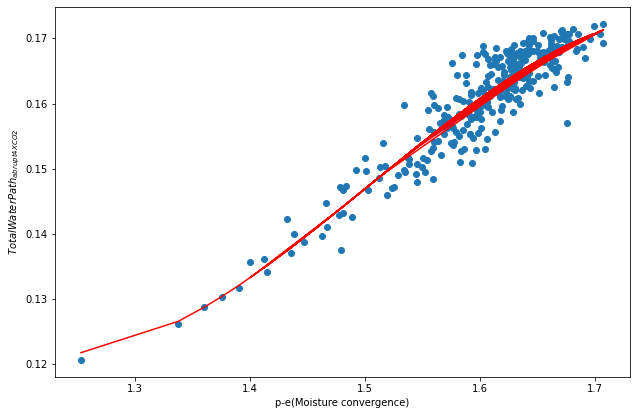

In [30]:
#..plot the LWP(TWP/IWP) trends with (moisture convergence) trendin the 150yr abrupt4XCO2 experiment:
fig  = plt.figure(figsize = (10.3, 6.8))
ax1  = plt.axes()

yy  = np.arange(300)

plt.scatter(p_e_area_yr, TWP_area_yr)   #..p_e_area_yr

plt.xlabel('p-e(Moisture convergence)')#..GMT(2-m air Temperature)
plt.ylabel('$Total  Water Path_{abrupt4XCO2}$')
#plt.ylim((0.08, 0.16))

parameter  = np.polyfit(p_e_area_yr, TWP_area_yr, 3)
#y  = parameter[0]*p_e_area_yr + parameter[1]
y  = parameter[0]*p_e_area_yr**3 + parameter[1]*p_e_area_yr**2 + parameter[2]*p_e_area_yr  + parameter[3]

plt.plot(p_e_area_yr, y, 'r')
plt.savefig('twp_abrupt_vs_moisture_convergence_IPSL.png')



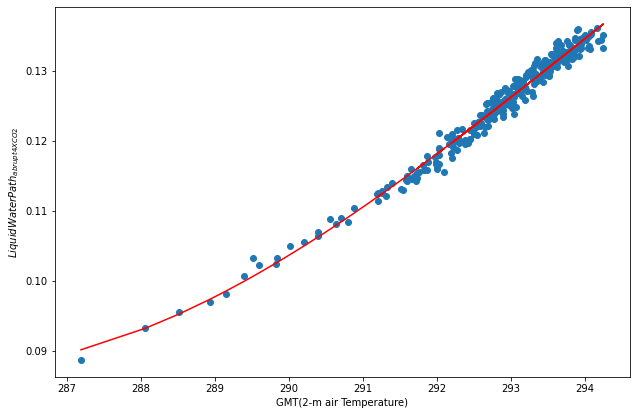

In [37]:
#..plot the p-e / LWP trends in the 150yr abrupt4XCO2 experiment:
fig  = plt.figure(figsize = (10.3, 6.8))
ax1  = plt.axes()

yy  = np.arange(300)

plt.scatter(GMT, LWP_area_yr)   #..p_e_area_yr

plt.xlabel('GMT(2-m air Temperature)')#..GMT(2-m air Temperature)
plt.ylabel('$Liquid Water Path_{abrupt4XCO2}$')
#plt.ylim((0.08, 0.16))

parameter  = np.polyfit(GMT, LWP_area_yr, 3)
#y  = parameter[0]*p_e_area_yr + parameter[1]
y  = parameter[0]*GMT**3 + parameter[1]*GMT**2 + parameter[2]*GMT  + parameter[3]

plt.plot(GMT , y, 'r')###..

plt.savefig('lwp_abrupt_vs_GMT_IPSL.png')


In [25]:
#..Standardized data:

GMT_afpre  = GMT
GMT_afpre  = (GMT - np.mean(GMT))  / np.std(GMT)

LWP_afpre  = LWP_area_yr
LWP_afpre =  (LWP_area_yr - np.mean(LWP_area_yr) )/np.std(LWP_area_yr)


SST_afpre  = SST_area_yr
SST_afpre =  (SST_area_yr - np.mean(SST_area_yr)) /np.std(SST_area_yr)

p_e_afpre =  p_e_area_yr
p_e_afpre =  (p_e_area_yr - np.mean(p_e_area_yr)) /np.std(p_e_area_yr)

LTS_afpre  = LTS_area_yr
LTS_afpre =  (LTS_area_yr - np.nanmean(LTS_area_yr)) /np.nanstd(LTS_area_yr)

SUB_afpre  = SUB_area_yr
SUB_afpre  = (SUB_area_yr - np.mean(SUB_area_yr)) /np.std(SUB_area_yr)

#..Subtract 'nan' in data, remains 300 points
ind5 =  np.isnan(LTS_area_yr)==False  
print(ind5.shape)

(300,)


In [31]:
#..linear regreesion of Cloud Controlling Factors (CCF) to GMT:

regr = linear_model.LinearRegression()
re_LWP = regr.fit(gmt_bin_pred[ind3].reshape(-1,1), LWP_bin_pred[ind3])

print(re_LWP.coef_)
print(re_LWP.intercept_)

regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
regr3 = linear_model.LinearRegression()
regr4 = linear_model.LinearRegression()
re_SST = regr1.fit(gmt_bin_pred[ind3].reshape(-1,1), SST_bin_pred[ind3])
re_p_e = regr2.fit(gmt_bin_pred[ind3].reshape(-1,1), p_e_bin_pred[ind3])
re_LTS = regr3.fit(gmt_bin_pred[ind3].reshape(-1,1), LTS_bin_pred[ind3])

re_SUB = regr4.fit(gmt_bin_pred[ind3].reshape(-1,1), SUB_bin_pred[ind3])
print(re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_ )

dX_dTg  = [re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_]






[0.00722776]
-2.015263346210882
[1.22242146] [0.0601984] [-0.09385316] [0.00015433]


In [32]:

coef1  = np.load('sensitivity_4ccfs_ipsl.npy')
intercept1  = np.load('intercept1_ipsl.npy')

np.save( 'CCFs_changes_T_ipsl.npy', dX_dTg )

intercept0  = np.load('intercept1.npy')
print(intercept0)

-0.49490642674103835


In [33]:
print(coef1)
print(intercept1)

[ 0.00260983  0.00953104 -0.00220453  0.41585783]
-0.6047988210526626


(4, 300)
(300,)
(1, 300)


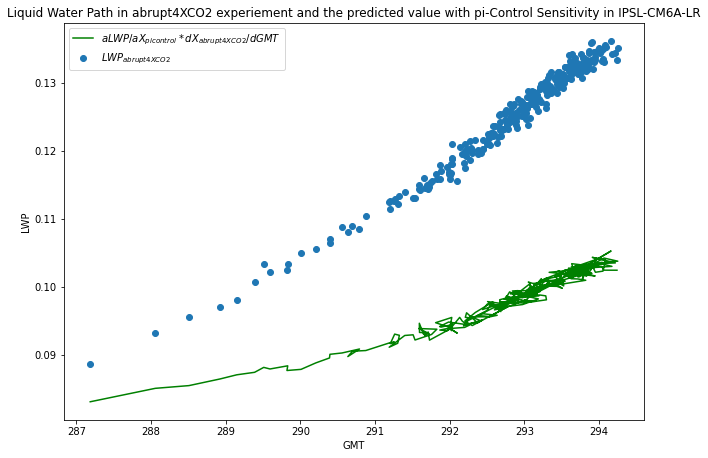

In [35]:
#..draw the plot for 'abrupt4' experiment's LWP and the predicted LWP from linear Regression Model trained in 'pi-control'

fig2  = plt.figure(figsize = (10.4, 7.3))
ax2  = plt.axes()

plt.scatter(GMT, LWP_area_yr, label='$LWP_{abrupt4XCO2}$')

XX  = np.array([SST_area_yr, p_e_area_yr, LTS_area_yr, SUB_area_yr])
print(XX.shape)

yr =  np.dot(coef1.reshape(1,-1), XX)
predicted_LWP  = yr  + intercept1
#print(yr)

print(np.array(GMT).shape)
print(np.array(predicted_LWP).shape)

plt.plot(GMT,predicted_LWP.flatten(), "g", label='$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}$')
#plt.ylim((0.105, 0.121))


plt.xlabel('GMT')
plt.ylabel('LWP')
plt.title("Liquid Water Path in abrupt4XCO2 experiement and the predicted value with pi-Control Sensitivity in IPSL-CM6A-LR")  #..!!

plt.legend()
plt.savefig("Linear_Regression_IPSLabrupt.png")










In [36]:
np.array(dX_dTg).reshape(-1,1)

dLWP_DTg  = np.dot(coef1.reshape(1,-1), np.array(dX_dTg).reshape(-1,1) )
print(dLWP_DTg)

[[0.00403515]]
